In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from src.mlhgp import MLHGP, HomGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.kshgp import KSHGP
from src.ksmlhgp import KSMLHGP
from src.ksimlhgp import KSIMLHGP
from src.rnmlhgp import RNHGP as RNHGP2
from src.rnimlhgp import RNHGP as RNHGP3
from src import evaluator

## SUPPRESS ALL WARNINGS
import warnings
warnings.filterwarnings("ignore")

import scienceplots
plt.style.use('science')

In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

# Problem Definition

In [3]:
df = pd.read_csv("data/lidar.csv")[["range","logratio"]]

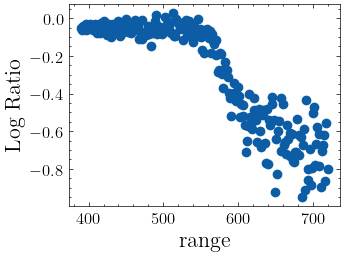

In [4]:
plt.scatter(df["range"], df["logratio"])
plt.xlabel("range")
plt.ylabel("Log Ratio")
plt.show()

## Single Pass

### Split train-test

In [5]:
df_train, df_test = train_test_split(df, train_size=0.15, random_state=42)

In [6]:
x_train = df_train["range"].values.reshape(-1,1)
y_train = df_train["logratio"].values.reshape(-1,1)
x_valid = df_test["range"].values.reshape(-1,1)
y_valid = df_test["logratio"].values.reshape(-1,1)
x_test = np.linspace(390,720,num=1000).reshape(-1,1)

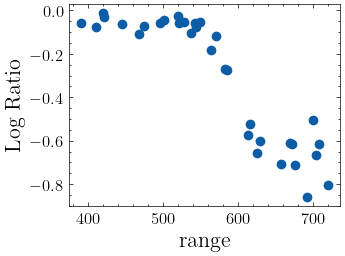

In [7]:
plt.scatter(df_train["range"], df_train["logratio"])
plt.xlabel("range")
plt.ylabel("Log Ratio")
plt.show()

### Normalize input feature

In [8]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(x_train)
x_train_norm = normalizer.transform(x_train)
x_valid_norm =  normalizer.transform(x_valid)
x_test_norm = normalizer.transform(x_test)

### Define models

In [9]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    hgps = [MLHGP,IMLHGP,NNPEHGP,KSMLHGP,KSIMLHGP]
    trained_hgps = []

    for hgp in hgps:
        # Initialize models
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
        gp_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)
        model_hgp = hgp(model=gp, model_noise=gp_noise)

        # fit the model
        model_hgp.fit(X_train_norm, y_train.flatten())
        trained_hgps.append(model_hgp)

    return trained_hgps

### Train and Predict

In [10]:
# Train
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-4, 8e-2)
)
hgp = hgp_constructor(x_train_norm, y_train, kernel, kernel_noise)

In [11]:
# make a prediction 
def predall(x_test_norm, hgp):
    model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
    res_dict = {}
    for idx,hgp_model in tqdm(enumerate(hgp)):
        subres_dict = {}
        Y_pred, Std_pred = hgp_model.predict(x_test_norm, return_std="multi")
        subres_dict["y_pred"] = Y_pred
        subres_dict["std_pred"] = Std_pred
        res_dict[model_name[idx]] = subres_dict
    
    return res_dict

In [12]:
vis_res_dict = predall(x_test_norm, hgp)
quant_res_dict = predall(x_valid_norm, hgp)

5it [00:00, 36.86it/s]
5it [00:00, 96.65it/s]


### Evaluation

#### Visual

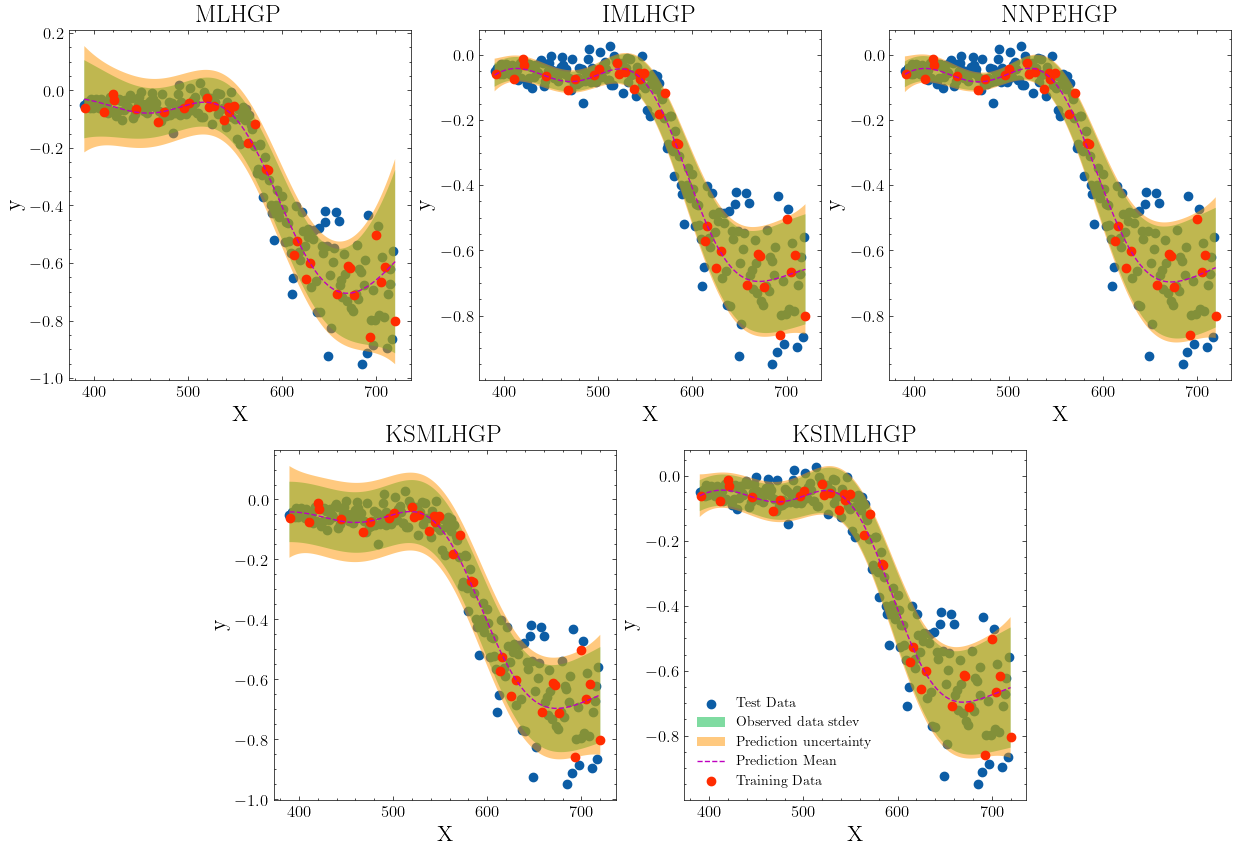

In [13]:
model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
fig = plt.figure(figsize=(15,10))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2, wspace=0.5) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
ax5 = fig.add_subplot(spec[1,3:5])

axs = [ax1,ax2,ax3,ax4,ax5]
idx = 0
for ax in axs:
    # Extract results
    name = model_name[idx]
    res = vis_res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    std_tot = np.sqrt(std_al**2 + std_ep**2)

    ax.scatter(x_valid,y_valid, label="Test Data")
    x = x_test.squeeze()
    ax.fill_between(
        x_test.ravel(),
        y_pred - 1.96 * (std_al),
        y_pred + 1.96 * (std_al),
        alpha=0.5,
        label=r"Observed data stdev",
    )
    ax.fill_between(
        x_test.ravel(),
        y_pred - 1.96 * std_tot,
        y_pred + 1.96 * std_tot,
        alpha=0.5,
        label=r"Prediction uncertainty",
    )
    ax.plot(x_test, y_pred, "--m", label="Prediction Mean")
    ax.scatter(x_train, y_train, label="Training Data")
    ax.set_title(name)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    # ax.legend()
    idx += 1

plt.legend()
plt.savefig("img/lidar_1d/one_realization.pdf", dpi=300, format="pdf")
plt.show()

In [14]:
for name,gp in zip(model_name,hgp):
    print(name)
    print(f"Kernel mean: {gp.model.kernel_}")
    try:
        print(f"Kernel noise: {gp.model_noise.kernel_}")
    except:
        pass

MLHGP
Kernel mean: 0.347**2 * RBF(length_scale=0.831) + WhiteKernel(noise_level=0.001)
Kernel noise: 3.28**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.08)
IMLHGP
Kernel mean: 0.381**2 * RBF(length_scale=0.765)
Kernel noise: 0.00502**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)
NNPEHGP
Kernel mean: 0.381**2 * RBF(length_scale=0.765)
Kernel noise: 0.00571**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)
KSMLHGP
Kernel mean: 0.363**2 * RBF(length_scale=0.801) + WhiteKernel(noise_level=0.001)
KSIMLHGP
Kernel mean: 0.381**2 * RBF(length_scale=0.765)


#### Quantitative

In [15]:
def score_eval(y_valid, y_pred, std_al, std_ep):

    # Compute NLPD
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    nlpd = evaluator.nlpd_loss(y_valid, y_pred, std_tot**2)

    return nlpd

In [16]:
for name in model_name:
    res = quant_res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    nlpd = score_eval(y_valid, y_pred, std_al, std_ep)
    print(name)
    print(f"NLPD: {nlpd}")

MLHGP
NLPD: 0.9540064233173775
IMLHGP
NLPD: 1.2624977306101142
NNPEHGP
NLPD: 1.3061802590718474
KSMLHGP
NLPD: 0.9840535474504489
KSIMLHGP
NLPD: 1.083631355202816


# Different runs with random seeds

In [17]:
def train_data_maker(seednum, train_frac=0.25):
    df = pd.read_csv("data/lidar.csv")[["range","logratio"]]
    df_train, df_test = train_test_split(df, train_size=train_frac, random_state=seednum)
    x_train = df_train["range"].values.reshape(-1,1)
    y_train = df_train["logratio"].values.reshape(-1,1)
    x_valid = df_test["range"].values.reshape(-1,1)
    y_valid = df_test["logratio"].values.reshape(-1,1)

    return x_train, y_train, x_valid, y_valid

In [18]:
def main(train_frac, repeat=100):

    model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
    metrics_name = ["nlpd", "model"]

    ## Initialize metrics dictionary
    model_scores = dict()
    for met in metrics_name:
        model_scores[met] = dict()
        for name in model_name:
            model_scores[met][name] = []
    
    model_scores["train_data"] = []
    model_scores["valid_data"] = []

    for i in tqdm(range(repeat)):
        X_train, y_train, X_valid, y_valid = train_data_maker(seednum=i, train_frac=train_frac)
        train = {"x": X_train, "y": y_train}
        valid = {"x": X_valid, "y": y_valid}
        model_scores["train_data"].append(train)
        model_scores["valid_data"].append(valid)
        
        # Test data
        X_test = np.linspace(390,720,num=1000).reshape(-1,1)
        
        # Normalize X
        normalizer = sklearn.preprocessing.StandardScaler().fit(x_train)
        X_train_norm = normalizer.transform(X_train)
        X_valid_norm =  normalizer.transform(X_valid)
        X_test_norm = normalizer.transform(X_test)

        # Train models
        kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1)
        )
        kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
            noise_level=1, noise_level_bounds=(1e-4, 8e-2)
        )
        hgp = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

        # make a prediction 
        res_dict = {}
        for idx,hgp_model in enumerate(hgp):
            subres_dict = {}
            Y_pred, Std_pred = hgp_model.predict(X_valid_norm, return_std="multi")
            subres_dict["y_pred"] = Y_pred
            subres_dict["std_pred"] = Std_pred
            res_dict[model_name[idx]] = subres_dict
            model_scores["model"][model_name[idx]].append(hgp_model)
        
        # Evaluate
        for name in model_name:
            res = res_dict[name]
            y_pred = res["y_pred"]
            std_al, std_ep = res["std_pred"]
            nlpd = score_eval(y_valid, y_pred, std_al, std_ep)
            model_scores["nlpd"][name].append(nlpd)
        
    return model_scores

In [19]:
model_scores = main(train_frac=0.15, repeat=50)

100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


In [25]:
params = {'xtick.labelsize':14,
          'ytick.labelsize':14,
          'axes.labelsize': 20,
          'axes.titlesize': 22}
plt.rcParams.update(params)

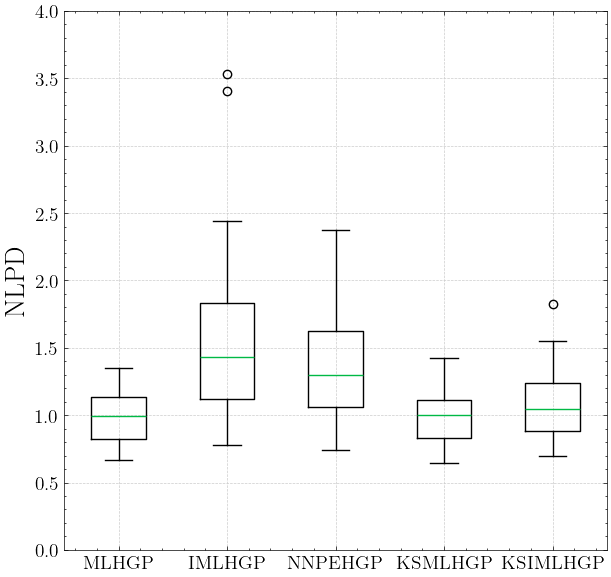

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["nlpd"].values())
ax.set_xticklabels(model_scores["nlpd"].keys())
ax.set_ylim(0,4)
ax.set_ylabel("NLPD")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/lidar_1d/nlpd.pdf", dpi=300, format="pdf")
plt.show()

In [21]:
def plot_samp(model, data_train, dataset_val, X_test_norm, X_test):
    Y_pred, Std_pred = model.predict(X_test_norm, return_std="multi")
    std_al, std_ep = Std_pred
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    
    xval = dataset_val["x"]
    yval = dataset_val["y"]
    plt.figure(figsize=(15, 5))
    plt.scatter(xval,yval, label="testing data")
    x = X_test.squeeze()
    plt.fill_between(
        X_test.ravel(),
        Y_pred - 1.96 * (std_al),
        Y_pred + 1.96 * (std_al),
        alpha=0.5,
        label=r"Observed data stdev",
    )
    plt.fill_between(
        X_test.ravel(),
        Y_pred - 1.96 * std_tot,
        Y_pred + 1.96 * std_tot,
        alpha=0.5,
        label=r"Prediction uncertainty",
    )
    plt.plot(np.linspace(390,720,num=1000), Y_pred, "--m")
    plt.scatter(data_train["x"], data_train["y"], label="training data")
    plt.legend()
    plt.show()

In [22]:
def locdef(model_type, condition = "best"):
    assert condition in ["best", "worst"]
    if condition == "best":
        loc = np.argmin(model_scores["nlpd"][model_type])
    else:
        loc = np.argmax(model_scores["nlpd"][model_type])
    
    return loc

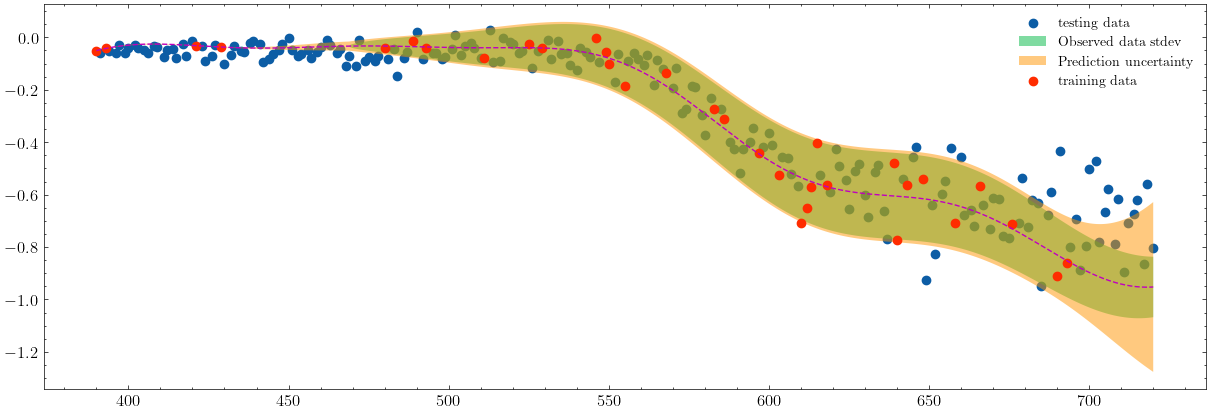

In [23]:
model_type = "IMLHGP"
condition = "worst"
location = locdef(model_type, condition)
model = model_scores["model"][model_type][location]
data_train = model_scores["train_data"][location]
data_valid = model_scores["valid_data"][location]
plot_samp(model, data_train, data_valid, x_test_norm, x_test)

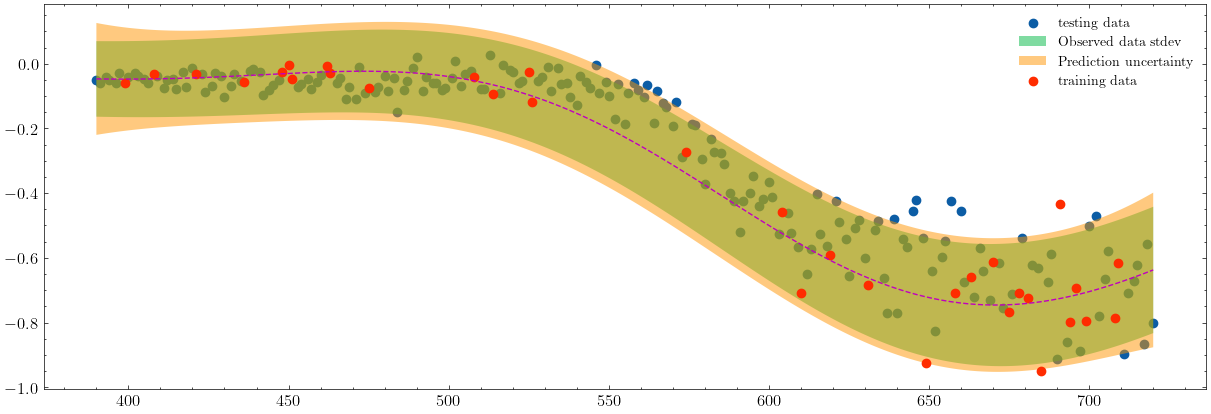

In [24]:
model_type = "KSMLHGP"
condition = "best"
location = locdef(model_type, condition)
model = model_scores["model"][model_type][location]
data_train = model_scores["train_data"][location]
data_valid = model_scores["valid_data"][location]
plot_samp(model, data_train, data_valid, x_test_norm, x_test)